In [1]:
#Imports

from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch
from tqdm.autonotebook import tqdm
import os
import time
import logging
import re
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import optuna
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

C:\Users\Mateo\AppData\Local\Temp\ipykernel_19900\1443433418.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
#Configuration

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

DATASET_PATH_TRAIN = Path("data/aclImdb/aclImdb/train")
DATASET_PATH_TEST = Path("data/aclImdb/aclImdb/test")

In [3]:
#Paramètres

NB_DOC_MAX = 1000 # par classe
IMDB_CLASSES  = ['neg','pos']
VOC_SIZE = 10000
BATCH_SIZE = 32
MAX_CHAR_SIZE = 1000

labels = dict(zip(IMDB_CLASSES,[0,1]))

In [4]:
#Chargement des données

def load_data(datapath, classes, max_size=None):
    txts = []
    files = []
    filelabels = []
    for label in classes:
        c = 0
        new = [os.path.join(datapath / label, f) for f in os.listdir(datapath / label) if f.endswith(".txt")]
        files += new
        # filelabels += [labels[label]] * len(new) 
        for file in (datapath / label).glob("*.txt"):
            t = file.read_text(encoding='utf8')
            txts.append(t if len(t)<MAX_CHAR_SIZE else t[:MAX_CHAR_SIZE])
            filelabels.append(labels[label])
            c+=1
            if max_size !=None and c>=max_size: break

    return txts, files, filelabels

txts, files, filelabels = load_data(DATASET_PATH_TRAIN, IMDB_CLASSES, max_size = NB_DOC_MAX)
txts_test, files_test, filelabels_test = load_data(DATASET_PATH_TEST, IMDB_CLASSES, max_size = NB_DOC_MAX)

Effectuons une première classification naïve avec 3 régresseurs standards.

In [5]:
# Préparation des données pour les classificateurs
classes = filelabels
corpus = txts

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

# Naïve Bayes
nb_clf = MultinomialNB()
nb_clf.fit(X, classes)

# Logistic Regression
lr_clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)
lr_clf.fit(X, classes)

# Linear SVM
svm_clf = LinearSVC(random_state=0, tol=1e-5, max_iter=1000)
svm_clf.fit(X, classes)

# Préparation des données de test
true = filelabels_test
test_corpus = txts_test
X_test = vectorizer.transform(test_corpus)

# Prédictions
pred_nb = nb_clf.predict(X_test)
pred_lr = lr_clf.predict(X_test)
pred_svm = svm_clf.predict(X_test)

# Évaluation
print(f"Naïve Bayes accuracy: {accuracy_score(true, pred_nb)*100}%")
print(f"Logistic Regression accuracy: {accuracy_score(true, pred_lr)*100}%")
print(f"SVM accuracy: {accuracy_score(true, pred_svm)*100}%")

Naïve Bayes accuracy: 0.812
Logistic Regression accuracy: 0.786
SVM accuracy: 0.781


C:\Users\Mateo\AppData\Local\miniconda3\envs\version_vguigue\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Ces scores nous donnent une première base de performances.

In [6]:
# Méthode Bag of Words
X_train = vectorizer.fit_transform(txts).toarray()
X_test = vectorizer.transform(txts_test).toarray()
vocab_size = X_train.shape[1]

# Convertir les labels en tenseurs PyTorch
y_train = torch.tensor(filelabels, dtype=torch.long)
y_test = torch.tensor(filelabels_test, dtype=torch.long)

# Conversion des données en tenseurs PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Définition du modèle
class BoWClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super(BoWClassifier, self).__init__()
        self.fc = nn.Linear(vocab_size, num_classes)

    def forward(self, x):
        return self.fc(x)

# Initialisation du modèle
num_classes = 2  # Positif ou négatif
model = BoWClassifier(vocab_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [7]:
# Entraînement et performances
# Liste pour stocker les valeurs de loss et accuracy
train_losses = []
test_losses = []
test_accuracies = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward
    loss.backward()
    optimizer.step()

    # Évaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        test_loss = criterion(outputs, y_test).item()
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).sum().item() / y_test.size(0)
    train_losses.append(loss.item())
    test_losses.append(test_loss)
    test_accuracies.append(accuracy*100)

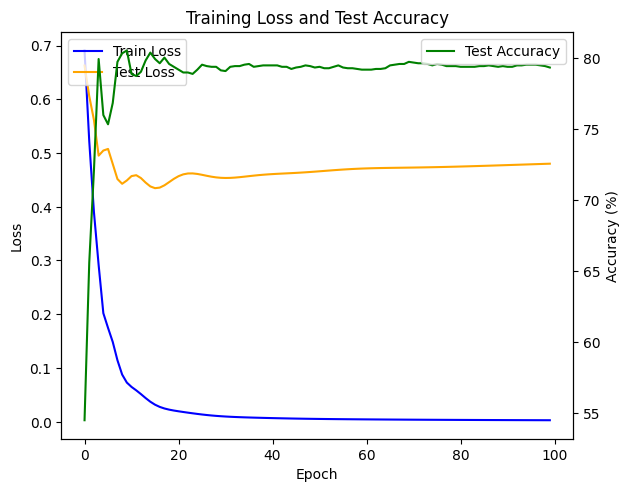

Meilleure accuracy :  80.55 %


In [8]:
# Tracé des courbes
fig, ax1 = plt.subplots()

# Courbe de la loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(test_losses, label='Test Loss', color='orange')
ax1.tick_params(axis='y')

# Courbe de l'accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)')
ax2.plot(test_accuracies, label='Test Accuracy', color='green')
ax2.tick_params(axis='y')

# Légende et affichage
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Training Loss and Test Accuracy')
plt.show()

print('Meilleure accuracy : ', max(test_accuracies), '%')

In [9]:
#Prétraitement

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

def preprocess_text(text):
    # Conversion en minuscules
    text = text.lower()

    # Suppression des nombres
    text = re.sub(r'\d+', '', text)

    # Suppression des ponctuations
    text = re.sub(r'[^\w\s]', '', text)

    # Suppression des stopwords
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Rejoindre les tokens en une chaîne
    text = ' '.join(tokens)

    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


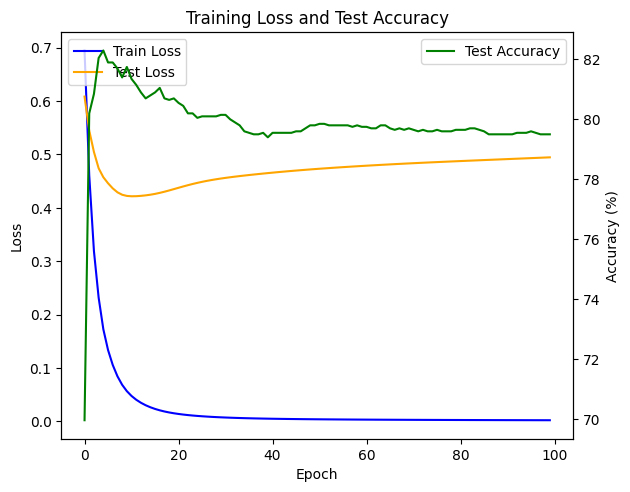

Meilleure accuracy :  82.3 %


In [10]:
# Chargement des données avec prétraitement
def load_data(datapath, classes, max_size=None):
    txts = []
    files = []
    filelabels = []
    for label in classes:
        c = 0
        new = [os.path.join(datapath / label, f) for f in os.listdir(datapath / label) if f.endswith(".txt")]
        files += new
        for file in (datapath / label).glob("*.txt"):
            t = file.read_text(encoding='utf8')
            t = preprocess_text(t)  # Appliquer le prétraitement
            txts.append(t if len(t) < MAX_CHAR_SIZE else t[:MAX_CHAR_SIZE])
            filelabels.append(labels[label])
            c += 1
            if max_size is not None and c >= max_size:
                break
    return txts, files, filelabels

# Chargement des données
txts, files, filelabels = load_data(DATASET_PATH_TRAIN, IMDB_CLASSES, max_size=NB_DOC_MAX)
txts_test, files_test, filelabels_test = load_data(DATASET_PATH_TEST, IMDB_CLASSES, max_size=NB_DOC_MAX)

# Méthode Bag of Words
X_train = vectorizer.fit_transform(txts).toarray()
X_test = vectorizer.transform(txts_test).toarray()
vocab_size = X_train.shape[1]

# Convertir les labels en tenseurs PyTorch
y_train = torch.tensor(filelabels, dtype=torch.long)
y_test = torch.tensor(filelabels_test, dtype=torch.long)

# Conversion des données en tenseurs PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Définition du modèle
class BoWClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super(BoWClassifier, self).__init__()
        self.fc = nn.Linear(vocab_size, num_classes)

    def forward(self, x):
        return self.fc(x)

# Initialisation du modèle
num_classes = 2  # Positif ou négatif
model = BoWClassifier(vocab_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Entraînement et performances
# Liste pour stocker les valeurs de loss et accuracy
train_losses = []
test_losses = []
test_accuracies = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward
    loss.backward()
    optimizer.step()

    # Évaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        test_loss = criterion(outputs, y_test).item()
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).sum().item() / y_test.size(0)
    train_losses.append(loss.item())
    test_losses.append(test_loss)
    test_accuracies.append(accuracy*100)

    # Tracé des courbes
fig, ax1 = plt.subplots()

# Courbe de la loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(test_losses, label='Test Loss', color='orange')
ax1.tick_params(axis='y')

# Courbe de l'accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)')
ax2.plot(test_accuracies, label='Test Accuracy', color='green')
ax2.tick_params(axis='y')

# Légende et affichage
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Training Loss and Test Accuracy')
plt.show()

print('Meilleure accuracy : ', max(test_accuracies), '%')

In [11]:
# Fonction d'objectif pour Optuna
def objective(trial):
    # Suggestion des hyperparamètres
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    num_epochs = trial.suggest_int('num_epochs', 10, 100)
    ngram_range = trial.suggest_categorical('ngram_range', [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3)])

    # Initialisation du modèle et de l'optimiseur
    model = BoWClassifier(vocab_size, num_classes)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # DataLoader avec la taille de batch spécifiée
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    # Entraînement et évaluation
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Évaluation sur l'ensemble de test
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test).item()
            _, predicted = torch.max(test_outputs, 1)
            accuracy = (predicted == y_test).sum().item() / y_test.size(0)

        # Report de l'accuracy à Optuna
        trial.report(accuracy, epoch)

        # Préparation pour l'early stopping
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

# Création de l'étude Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Affichage des résultats
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-02-09 23:57:48,941] A new study created in memory with name: no-name-d73de89d-3bfc-43fe-a3c8-41d591cbf250
C:\Users\Mateo\AppData\Local\Temp\ipykernel_19900\1172139119.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
C:\Users\Mateo\AppData\Local\miniconda3\envs\version_vguigue\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1) which is of type tuple.
  warnings.warn(message)
C:\Users\Mateo\AppData\Local\miniconda3\envs\version_vguigue\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but

Best trial:
  Value: 0.8505
  Params: 
    learning_rate: 0.00019923312143484492
    batch_size: 32
    num_epochs: 30
    ngram_range: (2, 2)


In [12]:
#passage au deep


GLOVE_PATH = Path("data/glove/glove")
DATASET_PATH = Path("data/aclImdb/aclImdb")

class FolderText(Dataset):
    """Dataset basé sur des dossiers (un par classe) et fichiers"""

    def __init__(self, classes, folder: Path, tokenizer, train_max_size=None, load=False):
        self.tokenizer = tokenizer
        self.files = []
        self.filelabels = []
        self.labels = {key: ix for ix, key in enumerate(classes)}
        
        for label in classes:
            c = 0
            for file in (folder / label).glob("*.txt"):
                self.files.append(file.read_text(encoding='utf8') if load else file)
                self.filelabels.append(self.labels[label])
                c += 1
                if train_max_size is not None and c > train_max_size:
                    break

    def __len__(self):
        return len(self.filelabels)
    
    def __getitem__(self, ix):
        s = self.files[ix]
        tokenized = torch.tensor(self.tokenizer(s if isinstance(s, str) else s.read_text()), device=device)
        label = torch.tensor(self.filelabels[ix], device=device)
        return tokenized, label

def get_imdb_data(embedding_size=50, train_max_size=None):
    """Renvoie l'ensemble des données nécessaires pour l'apprentissage 

    - dictionnaire word vers ID
    - embeddings (Glove)
    - DataSet (FolderText)

    """
    WORDS = re.compile(r"\S+")
    glove_fn = open(GLOVE_PATH / ("glove.6B.%dd.txt" % embedding_size), encoding='utf8')
    words, embeddings = [], []
    
    for line in glove_fn:
        values = line.split()
        words.append(values[0])
        embeddings.append([float(x) for x in values[1:]])

    OOVID = len(words)
    words.append("__OOV__")

    word2id = {word: ix for ix, word in enumerate(words)}
    embeddings = np.vstack((embeddings, np.zeros(embedding_size)))
    embeddings = torch.tensor(embeddings, dtype=torch.float32, device=device)

    def tokenizer(t):
        return [word2id.get(x, OOVID) for x in re.findall(WORDS, t.lower())]

    logging.info("Loading embeddings")
    logging.info("Get the IMDB dataset")
    
    return word2id, embeddings, FolderText(IMDB_CLASSES, DATASET_PATH / "train", tokenizer, train_max_size, load=True), FolderText(IMDB_CLASSES, DATASET_PATH / "test", tokenizer, train_max_size, load=True)

NameError: name 'Dataset' is not defined

In [ ]:
word2id, embeddings, train_dataset, test_dataset = get_imdb_data()

In [ ]:
# vérification des données chargées:

word2id
# embeddings
# train_dataset[0]

print(len(word2id), len(embeddings), len(embeddings[0]))


In [ ]:
#data loader

from torch.nn.utils.rnn import pad_sequence

BATCH_SIZE = 100

def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences], device=device)
    padded_sequences = pad_sequence(sequences, batch_first=False).to(device)
    labels = torch.tensor(labels, device=device)
    return padded_sequences, torch.tensor(lengths), torch.tensor(labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [ ]:
# Test

batch =next(iter( train_loader))
padded_sequences, lengths, labels = batch
print("Padded sequences:", padded_sequences)
print(padded_sequences.size())
# print("Lengths:", lengths)
print("Labels:", labels)



In [ ]:
#réseau
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class RNNSent(nn.Module):
    def __init__(self, hidden_size, output_size, embeddings, device):
        super(RNNSent, self).__init__()

        self.device = device
        self.hidden_size = hidden_size
        self.input_size = len(embeddings[0])

        self.emb = nn.Embedding(len(embeddings), len(embeddings[0]))

        # INITIALISATION des embeddings
        #self.emb.weight.data.copy_(torch.from_numpy(embeddings).to(device))
        self.emb.weight.requires_grad = False
        
        # Envoyer l'embedding layer sur le device
        self.emb.to(device)

        # CHOIX Du module récurrent
        self.rec = nn.RNN(self.input_size, self.hidden_size, nonlinearity='tanh').to(device)
        # self.rec = nn.LSTM(self.input_size, self.hidden_size).to(device)

        # ATTENTION
        self.attention = nn.Linear(hidden_size, 1, bias=False).to(device)

        self.h2o = nn.Linear(hidden_size, output_size).to(device)

    def forward(self, input, lengths=None):
        maxlen = input.size(0)
        batch_size = input.size(1)

        # Déplacer l'entrée sur le bon device
        input = input.to(self.device)
        if lengths is not None:
            lengths = lengths.to(self.device)

        # 1. translation of the input from int to emb
        xemb = self.emb(input).to(self.device)
        #print("xemb", xemb.size())

        # 2. Passage dans le rec
        hidden, last = self.rec(xemb)   # RNN
        # hidden, (last,c) = self.rec(xemb) # LSTM => last[-1]
        #print("hidden", hidden.size())

        # récupération des dernières couches (réelles, sans padding)
        if lengths is not None:
            last = torch.stack([hidden[lengths[i] - 1, i, :].to(self.device) for i in range(batch_size)])

        # 3. Ajout de l'attention (non nécessaire dans un premier temps)
        # 3.1 passage dans l'attention
        a = self.attention(hidden).squeeze(-1).to(self.device)
        #print(a.size())

        # 3.2 mask [à comprendre impérativement]
        mask = torch.arange(maxlen, device=self.device).unsqueeze(1).expand(maxlen, batch_size) < lengths.unsqueeze(0)
        #print(mask)
        masked_attn_scores = a.masked_fill(~mask, float('-inf'))

        # 3.3 calcul de l'attention (utilisation du softmax) + application sur les couches cachées
        a = F.softmax(masked_attn_scores, dim=0).unsqueeze(-1)
        #print("a", a.size())
        #print("hidden", hidden.size())

        last = torch.sum(a * hidden, dim=0)
        #print("last", last.size())

        output = self.h2o(last).squeeze(0)
        #output = self.h2o(last) # LSTM
        
        return output, hidden

In [ ]:
# choose hidden size
n_hidden = 128
output_size = 2
# build network
rnn = RNNSent( n_hidden,  output_size, embeddings, device)
rnn.name = "RNNSent-"+time.asctime()

In [ ]:
import torch

def list_tensors_by_device(model):
    device_count = {}
    for name, param in model.named_parameters():
        device = param.device
        if device not in device_count:
            device_count[device] = []
        device_count[device].append(name)

    for device, params in device_count.items():
        print(f"Device: {device}")
        for param in params:
            print(f"  {param}")

# Exemple d'utilisation avec ton modèle
list_tensors_by_device(rnn)

# Vérifier les tenseurs dans un batch
x, lengths, y = next(iter(train_loader))
print("x device:", x.device)
print("lengths device:", lengths.device)
print("y device:", y.device)


In [ ]:
loss = nn.CrossEntropyLoss().to(device)
# batch
x, lengths, y = next(iter(train_loader))
print(x.size(),y.size())

# Envoyer les tenseurs sur le device
x = x.to(device)
lengths = lengths.to(device)
y = y.to(device)

# maxlen = x.size()[0]
# mask = torch.arange(maxlen).unsqueeze(1).expand(maxlen, 100) < lengths.unsqueeze(0)
# print(mask)
yhat, hidden = rnn(x, lengths)
print(yhat.size())
l = loss(yhat,y)

In [ ]:
# définition de la métrique d'évaluation
def accuracy(yhat,y):
    # y encode les indexes, s'assurer de la bonne taille de tenseur
    assert len(y.shape)==1 or y.size(1)==1
    return (torch.argmax(yhat,1).view(y.size(0),-1)== y.view(-1,1)).float().mean()

In [ ]:
def train(model,epochs,train_loader,test_loader):
    optim = torch.optim.Adam(model.parameters(),lr=1e-3)    # choix optimizer
    model = model.to(device)
    print(f"running {model.name}")
    loss = nn.CrossEntropyLoss()                            # choix loss
    # 
    # loss = nn.CrossEntropyLoss(weight=cl_weight.to(device))                            # choix loss
    for epoch in tqdm(range(epochs)):
        cumloss, cumacc, count = 0, 0, 0
        model.train()
        for x, lengths, y in train_loader:                            # boucle sur les batchs
            optim.zero_grad()
            x,y = x.to(device), y.to(device)                # y doit être un tensor (pas un int)
            yhat, next_hidden = model(x, lengths)
            l = loss(yhat,y)
            l.backward()
            optim.step()
            cumloss += l*len(x)                             # attention, il peut y avoir un batch + petit (le dernier)
            cumacc += accuracy(yhat,y)*len(x)
            count += len(x)
        #writer.add_scalar('loss/train',cumloss/count,epoch)
        #writer.add_scalar('accuracy/train',cumacc/count,epoch)
        if epoch % 2 == 0:
            model.eval()
            with torch.no_grad():
                cumloss, cumacc, count = 0, 0, 0
                for x, lengths, y in test_loader:
                    x,y = x.to(device), y.to(device)
                    yhat, next_hidden = model(x, lengths)
                    cumloss += loss(yhat,y)*len(x)
                    cumacc += accuracy(yhat,y)*len(x)
                    count += len(x)
                #writer.add_scalar(f'loss/test',cumloss/count,epoch)
                #writer.add_scalar('accuracy/test',cumacc/count,epoch)

In [ ]:
def train(model, epochs, train_loader, test_loader):
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)  # choix optimizer
    model = model.to(device)
    print(f"running {model.name}")
    loss = nn.CrossEntropyLoss()  # choix loss
    # loss = nn.CrossEntropyLoss(weight=cl_weight.to(device))  # choix loss

    test_losses = []
    test_accuracies = []

    for epoch in tqdm(range(epochs)):
        cumloss, cumacc, count = 0, 0, 0
        model.train()
        for x, lengths, y in train_loader:  # boucle sur les batchs
            optim.zero_grad()
            x, y = x.to(device), y.to(device)  # y doit être un tensor (pas un int)
            yhat, next_hidden = model(x, lengths)
            l = loss(yhat, y)
            l.backward()
            optim.step()
            cumloss += l * len(x)  # attention, il peut y avoir un batch + petit (le dernier)
            cumacc += accuracy(yhat, y) * len(x)
            count += len(x)
        print(epoch)
        model.eval()
        with torch.no_grad():
            cumloss, cumacc, count = 0, 0, 0
            for x, lengths, y in test_loader:
                x, y = x.to(device), y.to(device)
                yhat, next_hidden = model(x, lengths)
                cumloss += loss(yhat, y) * len(x)
                cumacc += accuracy(yhat, y) * len(x)
                count += len(x)

            # Calcul des performances de test
            test_loss = cumloss / count
            test_acc = cumacc / count
            test_losses.append(test_loss)
            test_accuracies.append(test_acc)
            print(f"Epoch {epoch}: Test Loss = {test_loss:.4f}, Test Accuracy = {test_acc:.4f}")

    return model, test_losses, test_accuracies

In [ ]:
# ~10 minutes sur CPU
n_epoch = 20
a,b,c=train(rnn, n_epoch, train_loader, test_loader)
print(b)
print(c)